MonteCarlo simulation for geometricl efficiency estimation

In [29]:
import numpy as np
from scipy import special as sp
from scipy import constants as c
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
core_diam = 8.2*1e-6 # meters
lenght = 1 # meters
lam = 1555 * 1e-9 #meters

First we have to compute the number of photons coming out of the diode

In [14]:
P = 1.5*1e-3 #diode power
R0 = (P*lam)/(c.Planck*c.c) # photons per second

Then we have to account for 1m lenght of fiber

In [15]:
fiber_att = pow(10,(0.18/20))*lenght/1000 #W per m
R_in = R0*fiber_att*1/16*1e-8#rate of photons out of fiber in 1 ns
print("Total incoming photons in one SINGLE pulse are ca", int(R_in))

Total incoming photons in one SINGLE pulse are ca 7492


Airy diffraction formula

In [16]:
def airy(theta):
    a=core_diam
    k = 2*np.pi/lam
    x = k*a*np.sin(theta)
    return (2*sp.j1(x)/x)**2

Show plot of Airy formula

Text(0, 0.5, 'Airy')

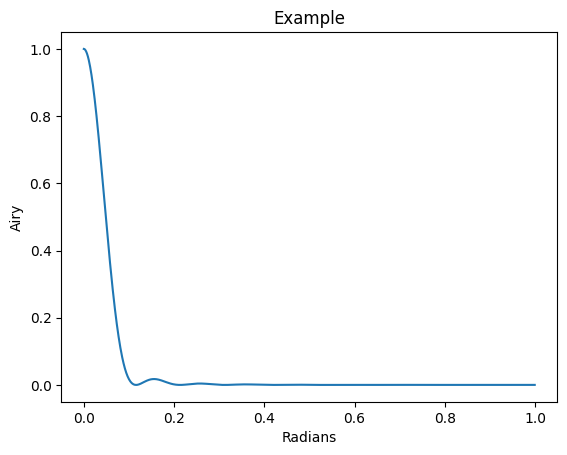

In [17]:
temp = np.arange(0.0001,1,0.001)
plt.plot(temp, airy(temp))
plt.title("Example")
plt.xlabel("Radians")
plt.ylabel("Airy")

In [18]:
z = 1
x = np.arange(0.000001,10,0.001)
ang = np.arctan(x/z)
R_out = R_in*airy(ang)

(0.0, 5.0)

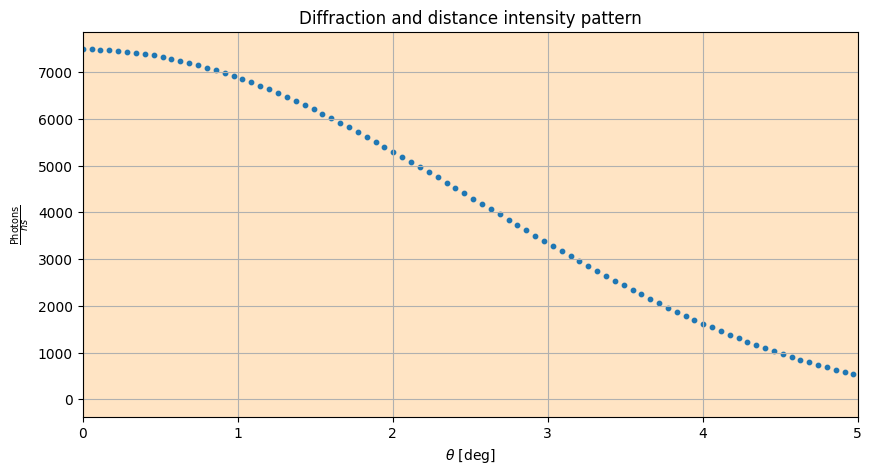

In [19]:
fig, axs = plt.subplots(figsize=(10,5))
plt.scatter(ang/np.pi*180, R_out, marker='o',s=10)
plt.title("Diffraction and distance intensity pattern")
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"$\frac{\text{Photons}}{ns}$")
plt.grid()
axs.set_facecolor('bisque')
#plt.colorbar(label="Radius dependence %", orientation="vertical") 
plt.xlim([0,5])

In [20]:
z = 1e3

Creating chip active area

In [21]:
x = {'xmin': [i * 1550 + 480 for i in range(8)], 'xmax': [i * 1550 + 730 for i in range(8)]} 

xactives = [(x['xmin'][i],x['xmax'][i]) for i in range(len(x['xmin']))]
yactives = [(1270,2030),(2230,2290)]

yplus = {'ymin': 2230, 'ymax': 2990}
yneg = {'ymin': 1270, 'ymax': 2030}
y = [1270,2030, 2230, 2990]

In [22]:
Ttime = 0.1 #total acquisition time in seconds
acq = np.arange(0,Ttime,30*1e-6)
print(len(acq))

N = int(R_in)
theta, hit = [], []
count = np.zeros(8)

for n in range(N):
    xax = np.random.uniform(low=0, high=max(x['xmax'])+250)
    yax = np.random.uniform(low=0, high=4265)
    for i in range(8):
        if (x['xmin'][i]<xax and xax<x['xmax'][i]):
            count[i] += 1
            theta.append(180/np.pi*np.arctan(np.sqrt(xax**2 + yax**2)/z))

3334


Histogram of counts before airy correction

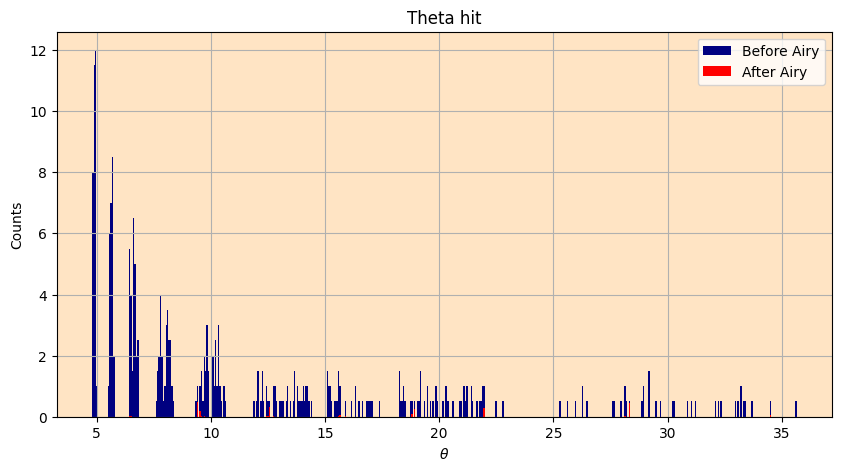

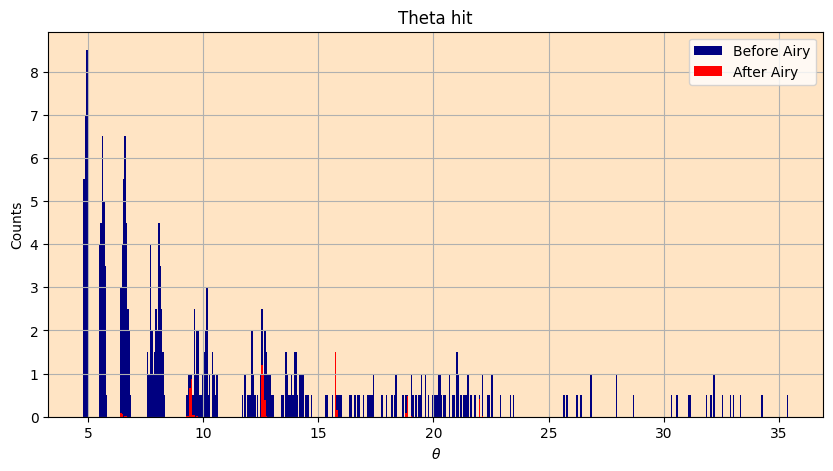

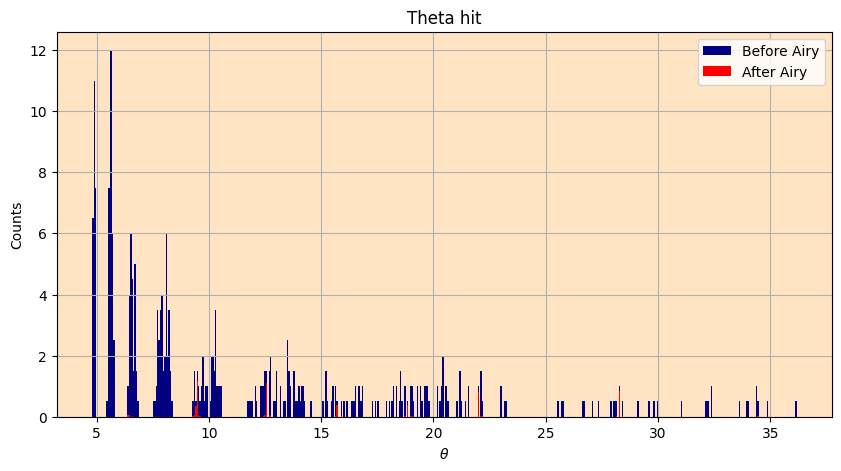

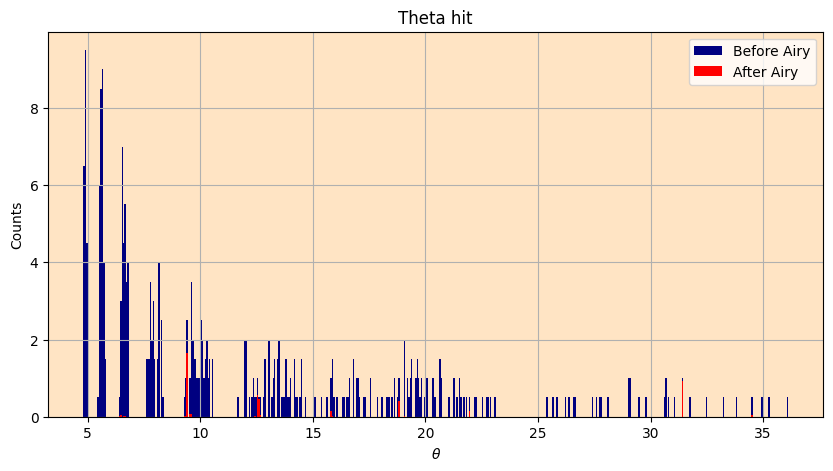

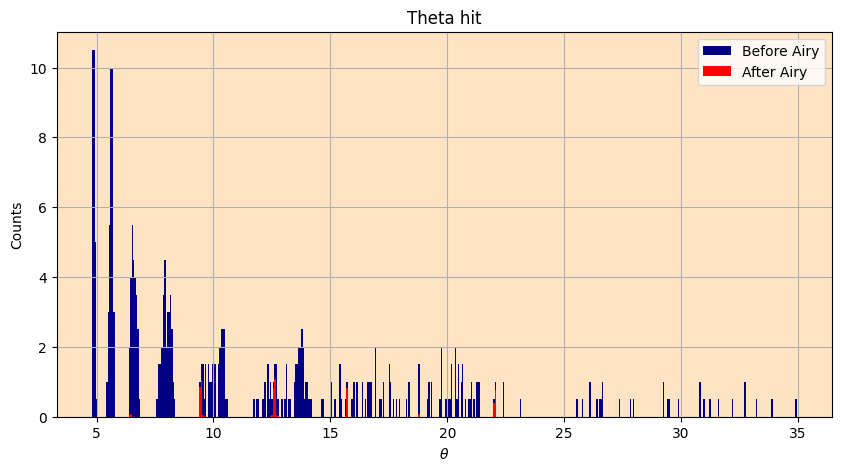

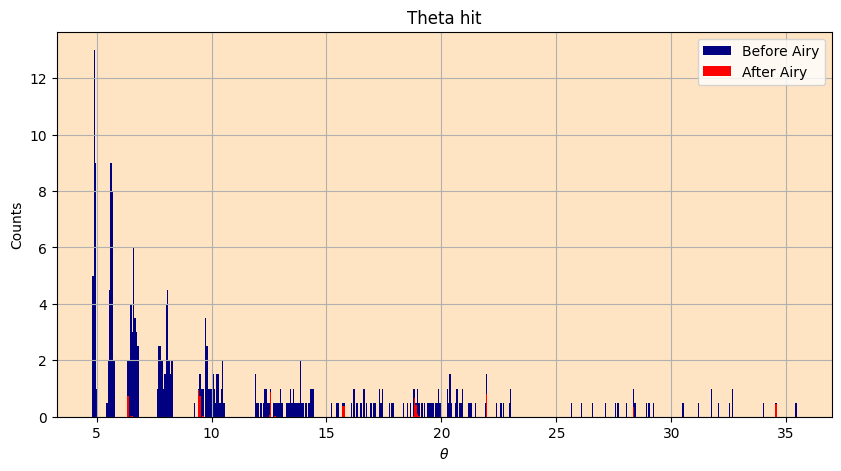

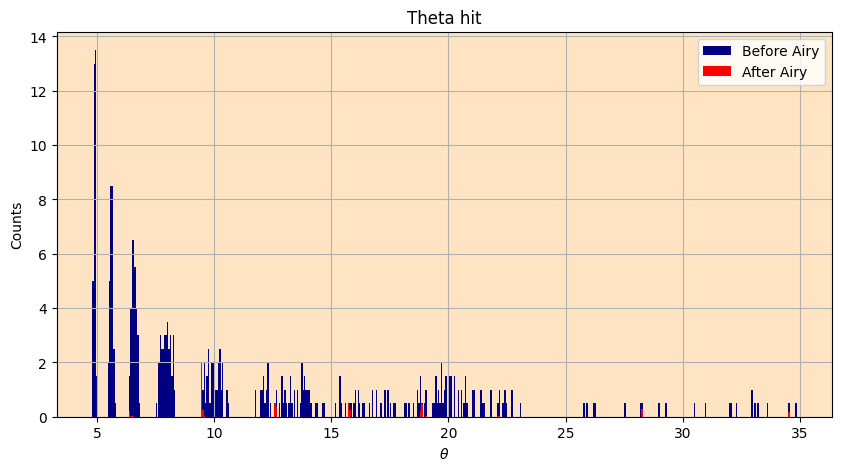

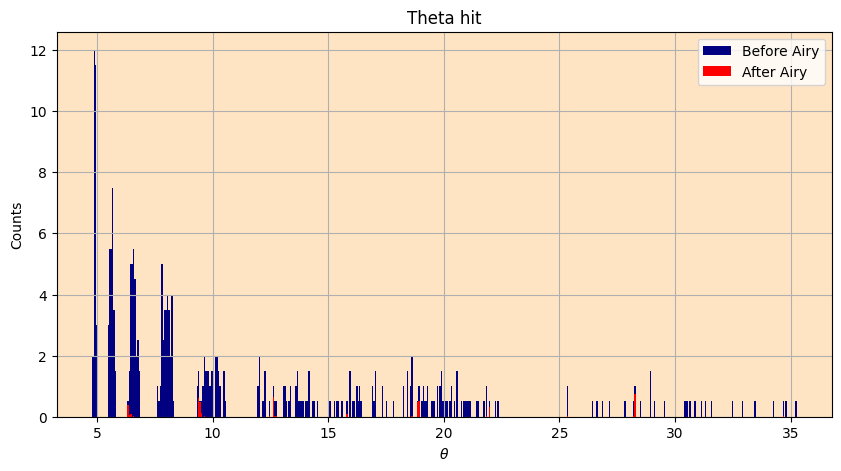

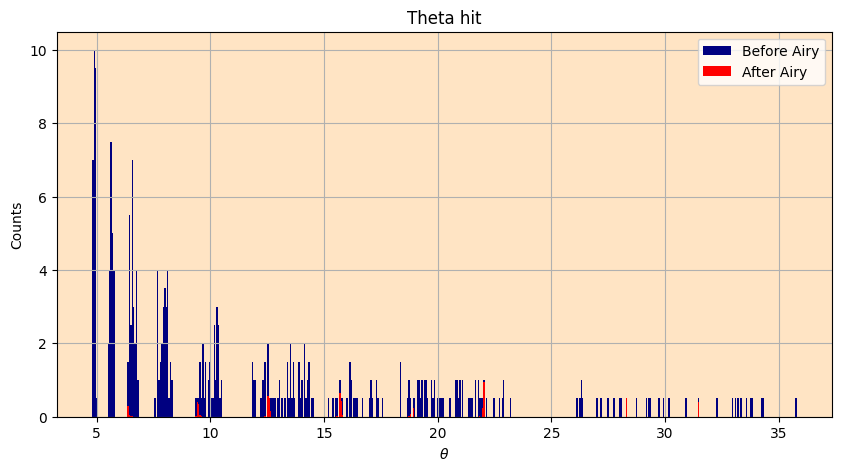

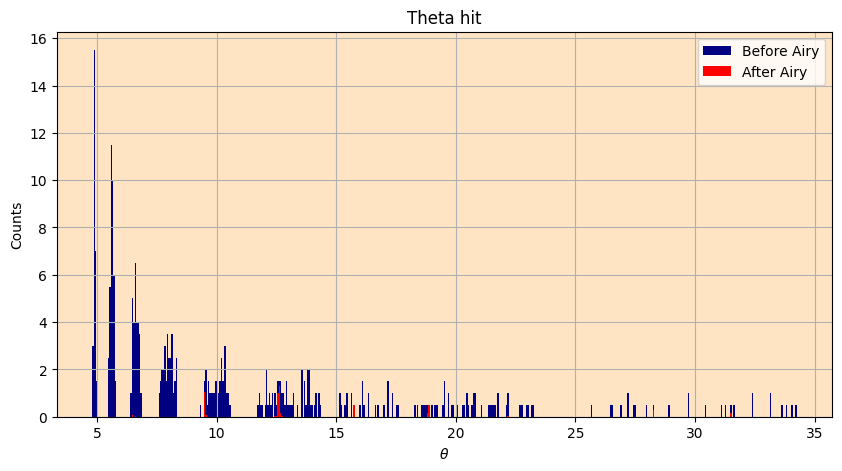

In [24]:
from datetime import date

for i in range(10):
    datab = np.array(df["theta"][i])
    bin_countb = 500
    binsb = np.linspace(min(df["theta"][i]), max(df["theta"][i]), bin_countb)
    data_entriesb, binsb = np.histogram(datab, bins=binsb)#, bins=bins)
    binscentersb = np.array([0.5 * (binsb[j] + binsb[j+1]) for j in range(len(binsb)-1)])

    heights = []
    for (height,theta) in zip(data_entriesb,binsb):
        heights.append(height*airy(theta))
        

    fig, axs = plt.subplots(figsize=(10,5))
    axs.set_facecolor("bisque")
    plt.bar(binscentersb, np.array(data_entriesb)/2, width=binsb[1] - binsb[0], color='navy', label=r'Before Airy');
    plt.bar(binscentersb, np.array(heights)/2, width=binsb[1] - binsb[0], color='red', label=r'After Airy');
    plt.xlabel(r"$\theta$")
    plt.xticks()
    plt.ylabel(r'Counts')
    plt.title(r'Theta hit')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig(r"F:\\LabIV\\QTLab2324\\IRSource\\MC-Geometry\\png\\simulation_"+str(i)+"_"+str(date.today())+".png")

In [26]:
print("Simulated Efficiency = ", df["counts"].sum()/(len(acq)))

Simulated Efficiency =  [3.26505411e-03 2.26036497e-03 6.73645921e-05 7.55552300e-04
 1.38674685e-03 1.76105934e-03 1.99021808e-03 2.13752319e-03]
